In [1]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

pd.set_option('max_columns',100)


import os
os.chdir('/Users/shubhamjain/Downloads/AV/IPL/')

In [2]:
## training data

ball_data = pd.read_csv('train/ball_by_ball_data.csv')
match_data = pd.read_csv('train/match_data.csv')
key_teams = pd.read_csv('train/key_teams.csv')
players = pd.read_csv('train/player_rosters.csv')
player_attributes = pd.read_csv('player_attributes.csv')

## test data

test_player = pd.read_csv('test/player_predictions.csv')
test_matches = pd.read_csv('test/matches_2018.csv')
test_extras = pd.read_csv('test/total_extras.csv')

## submission

sub_player = pd.read_csv('sample_submission/player_predictions.csv')
sub_extras = pd.read_csv('sample_submission/total_extras.csv')

In [3]:
batsman = pd.read_csv('saved/final_batsman.csv')
bowling = pd.read_csv('saved/final_bowler.csv')
xi = pd.read_csv('saved/playing_xi.csv')
runs_score = pd.read_csv('saved/runs_score.csv')

### Building features for training

In [4]:
ball_data.loc[ball_data['inning'] == 3,'inning'] = 1
ball_data.loc[ball_data['inning'] == 4,'inning'] = 2

ball_data['season'] = ball_data['match_id'].apply(lambda x: str(x).split('_')[0]).astype('int')
ball_data['match_id'] = ball_data['match_id'].apply(lambda x: str(x).split('_')[1]).astype('int')

match_data['match_id'] = match_data['match_id'].apply(lambda x: str(x).split('_')[1]).astype('int')

## selecting only last three seasons
ball_data_3 = ball_data[ball_data['season'] > 2014]
ball_data_3 = ball_data_3.merge(match_data, on =['season', 'match_id'], how='left')

In [5]:
val = ball_data_3[ball_data_3['season'] == 2017]
ball_data_3 = ball_data_3[ball_data_3['season'] < 2017]

In [6]:
bowler = pd.DataFrame(ball_data_3['bowler'].unique(), columns= ['bowler'])

In [7]:
## getting ids of bowlers
temp = players[players['Player'].isin(bowler['bowler'])][['player_id','Player']].drop_duplicates(keep='first').rename(columns = {'Player':'bowler'})

bowler = bowler.merge(temp, on ='bowler', how='left')
bowler.loc[bowler['bowler'] == 'B Kumar', 'player_id'] = 691
bowler.loc[bowler['bowler'] == 'J P Duminy', 'player_id'] = 677

## total overs bowled by each bowler

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season','match_id','bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: x.sum()).reset_index().rename(columns = {'over':'overs_bowled'})

bowler = bowler.merge(temp , on='bowler', how='left')

## total overs bowled by each bowler

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season','match_id','bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: x.sum()).reset_index().rename(columns = {'over':'overs_bowled2'})

bowler = bowler.merge(temp , on='bowler', how='left')

In [8]:
## consistency == total runs given / total overs bowled

temp = ball_data_3[ball_data_3['inning'] == 1].groupby('bowler')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':
                                                                                                       'consistency'})

bowler = bowler.merge(temp, on = 'bowler', how='left')
bowler['consistency'] = bowler['consistency']/bowler['overs_bowled']

## total wickets taken & attacking == wickets/ over bowled

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby('bowler')['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})

bowler = bowler.merge(temp , on='bowler', how='left')

bowler['attacking'] = bowler['wickets']/bowler['overs_bowled']

## dot % = dot/ balls 
temp = ball_data_3[ball_data_3['inning'] == 1]
temp = temp[temp['batsman_runs'] == 0].groupby(['bowler'])['ball'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns = {'ball':'dot%'})

bowler = bowler.merge(temp , on='bowler', how='left')
bowler['dot%'] = bowler['dot%'] / (bowler['overs_bowled']*6)

In [9]:
## consistency == total runs given / total overs bowled

temp = ball_data_3[ball_data_3['inning'] == 2].groupby('bowler')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':
                                                                                                       'consistency2'})

bowler = bowler.merge(temp, on = 'bowler', how='left')
bowler['consistency2'] = bowler['consistency2']/bowler['overs_bowled2']

## total wickets taken & attacking == wickets/ over bowled

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby('bowler')['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets2'})

bowler = bowler.merge(temp , on='bowler', how='left')

bowler['attacking2'] = bowler['wickets2']/bowler['overs_bowled2']

## dot % = dot/ balls 
temp = ball_data_3[ball_data_3['inning'] == 2]
temp = temp[temp['batsman_runs'] == 0].groupby(['bowler'])['ball'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns = {'ball':'dot%2'})

bowler = bowler.merge(temp , on='bowler', how='left')
bowler['dot%2'] = bowler['dot%2'] / (bowler['overs_bowled2']*6)

In [10]:
## strike rate = wickets / ball

bowler['strike_rate'] = bowler['wickets']/ (bowler['overs_bowled'] * 6) *100

## no of 4 or 5 wickets hauls

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out')].groupby(['season','match_id','bowler'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})

temp = temp.groupby(['bowler'])['wickets'].apply(lambda x: np.count_nonzero(x > 3)).reset_index().rename(columns = {'wickets':
                                                                                                            'hauls'})
bowler = bowler.merge(temp , on='bowler', how='left')
#bowler.fillna(0, inplace=True)

##2 strike rate = wickets / ball

bowler['strike_rate2'] = bowler['wickets2']/ (bowler['overs_bowled2'] * 6) *100

## no of 4 or 5 wickets hauls

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out')].groupby(['season','match_id','bowler'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets2'})

temp = temp.groupby(['bowler'])['wickets2'].apply(lambda x: np.count_nonzero(x > 3)).reset_index().rename(columns = {'wickets':
                                                                                                            'hauls2'})
bowler = bowler.merge(temp , on='bowler', how='left')
#bowler.fillna(0, inplace=True)

In [11]:
## player of match / matches played

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season','match_id'])['player_of_match'].apply(lambda x: x.head(1)).reset_index()
bowler['mom'] = bowler['bowler']

bowler['mom'] = bowler['mom'].map(temp['player_of_match'].value_counts()).fillna(0)

##2 player of match / matches played

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season','match_id'])['player_of_match'].apply(lambda x: x.head(1)).reset_index()
bowler['mom2'] = bowler['bowler']

bowler['mom2'] = bowler['mom2'].map(temp['player_of_match'].value_counts()).fillna(0)

## completed 4 overs / matches played

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season', 'match_id' , 'bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: np.count_nonzero(x == 4)).reset_index().rename(columns = {'over':'bharosa'})

bowler = bowler.merge(temp , on='bowler', how='left')

##2 completed 4 overs / matches played

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season', 'match_id' , 'bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: np.count_nonzero(x == 4)).reset_index().rename(columns = {'over':'bharosa2'})

bowler = bowler.merge(temp , on='bowler', how='left')

## match played = = experience

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season','bowler'])['match_id'].apply(lambda x: (x.nunique())).reset_index()
temp = temp.groupby('bowler')['match_id'].apply(lambda x: x.sum()).reset_index().rename(columns = {'match_id': 
                                                                                                   'experience'})
bowler = bowler.merge(temp , on='bowler', how='left')

bowler['avg_wickets'] = bowler['wickets']/ bowler['experience'] 

In [12]:
bowler.drop('wickets2_y',axis=1,inplace=True)
bowler = bowler.rename(columns = {'wickets2_x':'wickets2'})

##2 match played = = experience

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season','bowler'])['match_id'].apply(lambda x: (x.nunique())).reset_index()
temp = temp.groupby('bowler')['match_id'].apply(lambda x: x.sum()).reset_index().rename(columns = {'match_id': 
                                                                                                   'experience2'})
bowler = bowler.merge(temp , on='bowler', how='left')

bowler['avg_wickets2'] = bowler['wickets2']/ bowler['experience2'] 

## adding player's attributes -- bowling arm and bowling style

temp = player_attributes[['player_id', 'role' , 'bowling_style']]
bowler = bowler.merge(temp, on ='player_id', how='left')

## filling missing
bowler.loc[bowler['player_id'] == 153, 'bowling_style']  = 'Right-Arm Fast-Medium'
bowler.loc[bowler['player_id'] == 602, 'bowling_style']  = 'Right-Arm Fast-Medium'

bowler['bowling_arm'] = bowler['bowling_style'].apply(lambda x: str(x).split(" ")[0])
bowler['bowling_style'] = bowler['bowling_style'].apply(lambda x: str(x).split(" ")[1])


## auction price and country

temp = pd.read_csv('cricbuzz_ipl.csv').rename(columns = {'player':'bowler'})
bowler = bowler.merge(temp, on = 'bowler', how='left')

bowler.loc[bowler['bowler'] == 'B Kumar', 'Price'] = 850
bowler.loc[bowler['bowler'] == 'B Kumar', 'country'] = 'India'

bowler.loc[bowler['bowler'] == 'J P Duminy', 'Price'] = 100
bowler.loc[bowler['bowler'] == 'J P Duminy', 'country'] = 'Africa'

In [13]:
bowler

,bowler,player_id,overs_bowled,overs_bowled2,consistency,wickets,attacking,dot%,consistency2,wickets2,attacking2,dot%2,strike_rate,hauls,strike_rate2,mom,mom2,bharosa,bharosa2,experience,avg_wickets,experience2,avg_wickets2,role,bowling_style,bowling_arm,Price,country
0,Umesh Yadav,208,51.0,17.0,8.745098,17.0,0.333333,0.395425,8.705882,3.0,0.176471,0.460784,5.555556,0.0,2.941176,2.0,2.0,8.0,2.0,15.0,1.133333,6.0,0.500000,Bowler,Fast,Right-Arm,420.0,India
1,Morne Morkel,169,46.0,18.0,7.239130,17.0,0.369565,0.500000,8.722222,3.0,0.166667,0.416667,6.159420,0.0,2.777778,1.0,1.0,10.0,4.0,12.0,1.416667,5.0,0.600000,Bowler,Fast,Right-Arm,NaN,NaN
2,Shakib Al Hasan,359,25.0,20.0,7.280000,5.0,0.200000,0.400000,8.750000,4.0,0.200000,0.366667,3.333333,0.0,3.333333,0.0,0.0,4.0,3.0,7.0,0.714286,6.0,0.666667,Batting Allrounder,Orthodox,Left-Arm,NaN,NaN
3,Sunil Narine,437,51.0,24.0,7.117647,11.0,0.215686,0.447712,6.708333,7.0,0.291667,0.458333,3.594771,1.0,4.861111,0.0,0.0,12.0,6.0,13.0,0.846154,6.0,1.166667,Bowler,Offbreak,Right-Arm,850.0,Windies
4,Andre Russell,430,51.0,27.0,7.392157,20.0,0.392157,0.444444,8.037037,9.0,0.333333,0.462963,6.535948,0.0,5.555556,6.0,6.0,9.0,3.0,16.0,1.250000,9.0,1.000000,Bowling Allrounder,Fast,Right-Arm,700.0,Windies
5,Piyush Chawla,102,45.0,27.0,7.355556,12.0,0.266667,0.381481,7.259259,10.0,0.370370,0.320988,4.444444,0.0,6.172840,1.0,1.0,7.0,6.0,16.0,0.750000,8.0,1.250000,Bowling Allrounder,Legbreak,Right-Arm,420.0,India
6,Lasith Malinga,230,20.0,40.0,6.400000,8.0,0.400000,0.500000,7.425000,16.0,0.400000,0.433333,6.666667,0.0,6.666667,1.0,1.0,5.0,10.0,5.0,1.600000,10.0,1.600000,Bowler,Fast,Right-Arm,NaN,NaN
7,Vinay Kumar,153,13.0,40.0,10.076923,1.0,0.076923,0.294872,7.325000,9.0,0.225000,0.437500,1.282051,0.0,3.750000,0.0,0.0,1.0,6.0,4.0,0.250000,12.0,0.750000,Bowler,Fast-Medium,Right-Arm,100.0,India
8,Corey Anderson,519,NaN,4.0,NaN,NaN,NaN,NaN,8.250000,1.0,0.250000,0.416667,NaN,NaN,4.166667,0.0,0.0,NaN,0.0,NaN,NaN,2.0,0.500000,Batting Allrounder,Fast-Medium,Left-Arm,NaN,NaN
9,Jasprit Bumrah,487,36.0,31.0,9.277778,7.0,0.194444,0.324074,7.677419,11.0,0.354839,0.456989,3.240741,0.0,5.913978,0.0,0.0,9.0,5.0,9.0,0.777778,9.0,1.222222,Bowler,Medium,Right-Arm,700.0,India


In [14]:
##treating missing values
bowler.fillna(0, inplace=True)

In [15]:
val['dismissal_kind'].fillna('none',inplace=True)

### building training data

In [16]:
## just training for first inngs

val1 = val[val['inning'] == 1]
val1 = val1.groupby(['season','match_id','inning','batting_team','venue_id','bowler'])['dismissal_kind'].apply(lambda x:
                                                                                                       np.count_nonzero((x != 'none') &(x!='run out'))).reset_index()

val1 = val1.rename(columns = {'dismissal_kind': 'target'})

In [17]:
## getting no of overs and runs conceeded

temp = val[val['inning'] == 1]
temp = temp.groupby(['season','match_id','inning','batting_team','venue_id','bowler'])['batsman_runs'].apply(lambda x:x.sum()).reset_index()

val1 = val1.merge(temp, on =['season','match_id','inning','batting_team','venue_id','bowler'], how='left')

## overs

temp = val[val['inning'] == 1]
temp = temp.groupby(['season','match_id','inning','batting_team','venue_id','bowler'])['over'].apply(lambda x: x.nunique()).reset_index()

val1 = val1.merge(temp, on =['season','match_id','inning','batting_team','venue_id','bowler'], how='left')

In [18]:
bowler.columns

Index(['bowler', 'player_id', 'overs_bowled', 'overs_bowled2', 'consistency',
       'wickets', 'attacking', 'dot%', 'consistency2', 'wickets2',
       'attacking2', 'dot%2', 'strike_rate', 'hauls', 'strike_rate2', 'mom',
       'mom2', 'bharosa', 'bharosa2', 'experience', 'avg_wickets',
       'experience2', 'avg_wickets2', 'role', 'bowling_style', 'bowling_arm',
       'Price', 'country'],
      dtype='object')

In [19]:
val1 = val1.merge(bowler[['bowler','overs_bowled', 'consistency',
       'wickets', 'attacking', 'dot%', 'strike_rate', 'hauls', 'mom',
        'bharosa', 'experience', 'avg_wickets','role', 'bowling_style', 'bowling_arm',
       'Price', 'country']], on ='bowler', how='left')
val1.fillna(0,inplace=True)

In [20]:
val1.head()

,season,match_id,inning,batting_team,venue_id,bowler,target,batsman_runs,over,overs_bowled,consistency,wickets,attacking,dot%,strike_rate,hauls,mom,bharosa,experience,avg_wickets,role,bowling_style,bowling_arm,Price,country
0,2017,1,1,SRH,4,Aniket Choudhary,1,51,4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0,0,0,0.0,0
1,2017,1,1,SRH,4,Shane Watson,0,41,3,41.0,9.024390,10.0,0.243902,0.418699,4.065041,1.0,2.0,7.0,12.0,0.833333,Batting Allrounder,Fast-Medium,Right-Arm,400.0,Australia
2,2017,1,1,SRH,4,Sreenath Aravind,0,36,3,17.0,8.352941,5.0,0.294118,0.343137,4.901961,0.0,0.0,3.0,5.0,1.000000,Bowler,Fast-Medium,Left-Arm,0.0,0
3,2017,1,1,SRH,4,Stuart Binny,1,10,1,18.0,6.555556,3.0,0.166667,0.444444,2.777778,0.0,0.0,1.0,10.0,0.300000,Batting Allrounder,Medium,Right-Arm,50.0,India
4,2017,1,1,SRH,4,Travis Head,0,11,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0,0,0,0.0,0


In [21]:
## mean encoding

role_enc = val1.groupby('role')['target'].mean()
val1['role'] = val1['role'].map(role_enc)

style_enc = val1.groupby('bowling_style')['target'].mean()
val1['bowling_style'] = val1['bowling_style'].map(style_enc)

arm_enc = val1.groupby('bowling_arm')['target'].mean()
val1['bowling_arm'] = val1['bowling_arm'].map(arm_enc)

In [22]:
## avg wickets aganist each team

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'batting_team'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_aganist'})

val1 = val1.merge(temp, on= ['bowler','batting_team'], how='left')

In [23]:
## avg wickets at each venue

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'venue_id'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_venue'})

val1 = val1.merge(temp, on= ['bowler','venue_id'], how='left')

In [24]:
val1.fillna(0,inplace=True)

In [25]:
val1.columns

Index(['season', 'match_id', 'inning', 'batting_team', 'venue_id', 'bowler',
       'target', 'batsman_runs', 'over', 'overs_bowled', 'consistency',
       'wickets', 'attacking', 'dot%', 'strike_rate', 'hauls', 'mom',
       'bharosa', 'experience', 'avg_wickets', 'role', 'bowling_style',
       'bowling_arm', 'Price', 'country', 'wickets_aganist', 'wickets_venue'],
      dtype='object')

In [26]:
###

features = [ 'overs_bowled',
       'consistency', 'attacking', 'dot%', 'wickets', 'strike_rate', 'hauls',
       'mom', 'bharosa', 'experience', 'avg_wickets', 'role', 'bowling_style',
       'bowling_arm', 'Price', 'wickets_aganist', 'wickets_venue']

target = val1['target']

In [27]:
rf = RandomForestRegressor(n_estimators= 600, max_depth= 14, oob_score= True)

In [28]:
rf.fit(val1[features], target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

### for 2 inngs

In [29]:
## just training for second inngs

val2 = val[val['inning'] == 2]
val2 = val2.groupby(['season','match_id','inning','batting_team','venue_id','bowler'])['dismissal_kind'].apply(lambda x:
                                                                                                       np.count_nonzero((x != 'none') &(x!='run out'))).reset_index()
val2 = val2.rename(columns = {'dismissal_kind': 'target'})

## getting no of overs and runs conceeded

temp = val[val['inning'] == 2]
temp = temp.groupby(['season','match_id','inning','batting_team','venue_id','bowler'])['batsman_runs'].apply(lambda x:x.sum()).reset_index()

val2 = val2.merge(temp, on =['season','match_id','inning','batting_team','venue_id','bowler'], how='left')

## overs

temp = val[val['inning'] == 2]
temp = temp.groupby(['season','match_id','inning','batting_team','venue_id','bowler'])['over'].apply(lambda x: x.nunique()).reset_index()

val2 = val2.merge(temp, on =['season','match_id','inning','batting_team','venue_id','bowler'], how='left')

In [30]:
bowler.columns

Index(['bowler', 'player_id', 'overs_bowled', 'overs_bowled2', 'consistency',
       'wickets', 'attacking', 'dot%', 'consistency2', 'wickets2',
       'attacking2', 'dot%2', 'strike_rate', 'hauls', 'strike_rate2', 'mom',
       'mom2', 'bharosa', 'bharosa2', 'experience', 'avg_wickets',
       'experience2', 'avg_wickets2', 'role', 'bowling_style', 'bowling_arm',
       'Price', 'country'],
      dtype='object')

In [31]:
val2 = val2.merge(bowler[['bowler','overs_bowled2', 'consistency2',
       'wickets2', 'attacking2', 'dot%2', 'strike_rate2', 'hauls', 'mom2',
        'bharosa2', 'experience2', 'avg_wickets2','role', 'bowling_style', 'bowling_arm',
       'Price', 'country']], on ='bowler', how='left')
val2.fillna(0,inplace=True)

In [32]:
## mean encoding

role_enc2 = val2.groupby('role')['target'].mean()
val2['role'] = val2['role'].map(role_enc2)

style_enc2 = val2.groupby('bowling_style')['target'].mean()
val2['bowling_style'] = val2['bowling_style'].map(style_enc2)

arm_enc2 = val2.groupby('bowling_arm')['target'].mean()
val2['bowling_arm'] = val2['bowling_arm'].map(arm_enc2)

In [33]:
## avg wickets aganist each team

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'batting_team'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_aganist'})

val2 = val2.merge(temp, on= ['bowler','batting_team'], how='left')

In [34]:
## avg wickets at each venue

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'venue_id'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_venue'})

val2 = val2.merge(temp, on= ['bowler','venue_id'], how='left')

In [35]:
val2.fillna(0,inplace=True)

In [36]:
val2.columns

Index(['season', 'match_id', 'inning', 'batting_team', 'venue_id', 'bowler',
       'target', 'batsman_runs', 'over', 'overs_bowled2', 'consistency2',
       'wickets2', 'attacking2', 'dot%2', 'strike_rate2', 'hauls', 'mom2',
       'bharosa2', 'experience2', 'avg_wickets2', 'role', 'bowling_style',
       'bowling_arm', 'Price', 'country', 'wickets_aganist', 'wickets_venue'],
      dtype='object')

In [37]:
###

features2 = ['overs_bowled2', 'consistency2',
       'wickets2', 'attacking2', 'dot%2', 'strike_rate2', 'hauls', 'mom2',
       'bharosa2', 'experience2', 'avg_wickets2', 'role', 'bowling_style',
       'bowling_arm', 'Price', 'wickets_aganist', 'wickets_venue']

target2 = val2['target']

In [38]:
## training

rf2 = RandomForestRegressor(n_estimators= 800, max_depth= 15, oob_score=True)
rf2.fit(val2[features2], target2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

### features for test data

In [39]:
## selecting only last three seasons
ball_data_3 = ball_data[ball_data['season'] > 2014]
ball_data_3 = ball_data_3.merge(match_data, on =['season', 'match_id'], how='left')

In [40]:
bowler = pd.DataFrame(ball_data_3['bowler'].unique(), columns= ['bowler'])

In [41]:
## getting ids of bowlers
temp = players[players['Player'].isin(bowler['bowler'])][['player_id','Player']].drop_duplicates(keep='first').rename(columns = {'Player':'bowler'})

bowler = bowler.merge(temp, on ='bowler', how='left')
bowler.loc[bowler['bowler'] == 'B Kumar', 'player_id'] = 691
bowler.loc[bowler['bowler'] == 'J P Duminy', 'player_id'] = 677

## total overs bowled by each bowler

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season','match_id','bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: x.sum()).reset_index().rename(columns = {'over':'overs_bowled'})

bowler = bowler.merge(temp , on='bowler', how='left')

## total overs bowled by each bowler

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season','match_id','bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: x.sum()).reset_index().rename(columns = {'over':'overs_bowled2'})

bowler = bowler.merge(temp , on='bowler', how='left')

In [42]:
## consistency == total runs given / total overs bowled

temp = ball_data_3[ball_data_3['inning'] == 1].groupby('bowler')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':
                                                                                                       'consistency'})

bowler = bowler.merge(temp, on = 'bowler', how='left')
bowler['consistency'] = bowler['consistency']/bowler['overs_bowled']

## total wickets taken & attacking == wickets/ over bowled

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby('bowler')['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})

bowler = bowler.merge(temp , on='bowler', how='left')

bowler['attacking'] = bowler['wickets']/bowler['overs_bowled']

## dot % = dot/ balls 
temp = ball_data_3[ball_data_3['inning'] == 1]
temp = temp[temp['batsman_runs'] == 0].groupby(['bowler'])['ball'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns = {'ball':'dot%'})

bowler = bowler.merge(temp , on='bowler', how='left')
bowler['dot%'] = bowler['dot%'] / (bowler['overs_bowled']*6)

In [43]:
## consistency == total runs given / total overs bowled

temp = ball_data_3[ball_data_3['inning'] == 2].groupby('bowler')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':
                                                                                                       'consistency2'})

bowler = bowler.merge(temp, on = 'bowler', how='left')
bowler['consistency2'] = bowler['consistency2']/bowler['overs_bowled2']

## total wickets taken & attacking == wickets/ over bowled

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby('bowler')['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets2'})

bowler = bowler.merge(temp , on='bowler', how='left')

bowler['attacking2'] = bowler['wickets2']/bowler['overs_bowled2']

## dot % = dot/ balls 
temp = ball_data_3[ball_data_3['inning'] == 2]
temp = temp[temp['batsman_runs'] == 0].groupby(['bowler'])['ball'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns = {'ball':'dot%2'})

bowler = bowler.merge(temp , on='bowler', how='left')
bowler['dot%2'] = bowler['dot%2'] / (bowler['overs_bowled2']*6)

In [44]:
## strike rate = wickets / ball

bowler['strike_rate'] = bowler['wickets']/ (bowler['overs_bowled'] * 6) *100

## no of 4 or 5 wickets hauls

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out')].groupby(['season','match_id','bowler'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})

temp = temp.groupby(['bowler'])['wickets'].apply(lambda x: np.count_nonzero(x > 3)).reset_index().rename(columns = {'wickets':
                                                                                                            'hauls'})
bowler = bowler.merge(temp , on='bowler', how='left')
#bowler.fillna(0, inplace=True)

##2 strike rate = wickets / ball

bowler['strike_rate2'] = bowler['wickets2']/ (bowler['overs_bowled2'] * 6) *100

## no of 4 or 5 wickets hauls

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out')].groupby(['season','match_id','bowler'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets2'})

temp = temp.groupby(['bowler'])['wickets2'].apply(lambda x: np.count_nonzero(x > 3)).reset_index().rename(columns = {'wickets':
                                                                                                            'hauls2'})
bowler = bowler.merge(temp , on='bowler', how='left')
#bowler.fillna(0, inplace=True)

In [45]:
## player of match / matches played

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season','match_id'])['player_of_match'].apply(lambda x: x.head(1)).reset_index()
bowler['mom'] = bowler['bowler']

bowler['mom'] = bowler['mom'].map(temp['player_of_match'].value_counts()).fillna(0)

##2 player of match / matches played

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season','match_id'])['player_of_match'].apply(lambda x: x.head(1)).reset_index()
bowler['mom2'] = bowler['bowler']

bowler['mom2'] = bowler['mom2'].map(temp['player_of_match'].value_counts()).fillna(0)

## completed 4 overs / matches played

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season', 'match_id' , 'bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: np.count_nonzero(x == 4)).reset_index().rename(columns = {'over':'bharosa'})

bowler = bowler.merge(temp , on='bowler', how='left')

##2 completed 4 overs / matches played

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season', 'match_id' , 'bowler'])['over'].apply(lambda x: x.nunique()).reset_index()
temp = temp.groupby('bowler')['over'].apply(lambda x: np.count_nonzero(x == 4)).reset_index().rename(columns = {'over':'bharosa2'})

bowler = bowler.merge(temp , on='bowler', how='left')

## match played = = experience

temp = ball_data_3[ball_data_3['inning'] == 1].groupby(['season','bowler'])['match_id'].apply(lambda x: (x.nunique())).reset_index()
temp = temp.groupby('bowler')['match_id'].apply(lambda x: x.sum()).reset_index().rename(columns = {'match_id': 
                                                                                                   'experience'})
bowler = bowler.merge(temp , on='bowler', how='left')

bowler['avg_wickets'] = bowler['wickets']/ bowler['experience'] 

In [46]:
bowler.drop('wickets2_y',axis=1,inplace=True)
bowler = bowler.rename(columns = {'wickets2_x':'wickets2'})

##2 match played = = experience

temp = ball_data_3[ball_data_3['inning'] == 2].groupby(['season','bowler'])['match_id'].apply(lambda x: (x.nunique())).reset_index()
temp = temp.groupby('bowler')['match_id'].apply(lambda x: x.sum()).reset_index().rename(columns = {'match_id': 
                                                                                                   'experience2'})
bowler = bowler.merge(temp , on='bowler', how='left')

bowler['avg_wickets2'] = bowler['wickets2']/ bowler['experience2'] 

## adding player's attributes -- bowling arm and bowling style

temp = player_attributes[['player_id', 'role' , 'bowling_style']]
bowler = bowler.merge(temp, on ='player_id', how='left')

## filling missing
bowler.loc[bowler['player_id'] == 153, 'bowling_style']  = 'Right-Arm Fast-Medium'
bowler.loc[bowler['player_id'] == 602, 'bowling_style']  = 'Right-Arm Fast-Medium'

bowler['bowling_arm'] = bowler['bowling_style'].apply(lambda x: str(x).split(" ")[0])
bowler['bowling_style'] = bowler['bowling_style'].apply(lambda x: str(x).split(" ")[1])


## auction price and country

temp = pd.read_csv('cricbuzz_ipl.csv').rename(columns = {'player':'bowler'})
bowler = bowler.merge(temp, on = 'bowler', how='left')

bowler.loc[bowler['bowler'] == 'B Kumar', 'Price'] = 850
bowler.loc[bowler['bowler'] == 'B Kumar', 'country'] = 'India'

bowler.loc[bowler['bowler'] == 'J P Duminy', 'Price'] = 100
bowler.loc[bowler['bowler'] == 'J P Duminy', 'country'] = 'Africa'

In [47]:
bowler.fillna(0,inplace=True)

In [48]:
bowler.head()

,bowler,player_id,overs_bowled,overs_bowled2,consistency,wickets,attacking,dot%,consistency2,wickets2,attacking2,dot%2,strike_rate,hauls,strike_rate2,mom,mom2,bharosa,bharosa2,experience,avg_wickets,experience2,avg_wickets2,role,bowling_style,bowling_arm,Price,country
0,Tymal Mills,621.0,8.0,10.0,6.750000,3.0,0.375000,0.562500,9.000000,2.0,0.200000,0.366667,6.250000,0.0,3.333333,0.0,0.0,2.0,2.0,2.0,1.500000,3.0,0.666667,Bowler,Fast-Medium,Left-Arm,0.0,0
1,Aniket Choudhary,480.0,8.0,9.0,8.500000,3.0,0.375000,0.458333,7.666667,2.0,0.222222,0.500000,6.250000,0.0,3.703704,0.0,0.0,2.0,1.0,2.0,1.500000,3.0,0.666667,Bowler,Medium,Left-Arm,30.0,India
2,Yuzvendra Chahal,682.0,64.0,78.0,8.281250,27.0,0.421875,0.359375,7.538462,31.0,0.397436,0.384615,7.031250,0.0,6.623932,0.0,0.0,13.0,15.0,19.0,1.421053,21.0,1.476190,Bowler,Legbreak,Right-Arm,600.0,India
3,Sreenath Aravind,237.0,34.0,45.0,8.117647,9.0,0.264706,0.333333,7.266667,15.0,0.333333,0.459259,4.411765,0.0,5.555556,0.0,0.0,6.0,7.0,10.0,0.900000,14.0,1.071429,Bowler,Fast-Medium,Left-Arm,0.0,0
4,Shane Watson,175.0,52.0,61.0,9.519231,12.0,0.230769,0.394231,7.524590,19.0,0.311475,0.428962,3.846154,1.0,5.191257,2.0,2.0,9.0,11.0,15.0,0.800000,19.0,1.000000,Batting Allrounder,Fast-Medium,Right-Arm,400.0,Australia


### building test data

In [49]:
xi = pd.read_csv('saved/playing_xi.csv')

## adding player id to playing xi 
df = players[players['Season'] == 2018][['player_id','Player']]
xi = xi.rename(columns = {'player':'Player'})
xi = xi.merge(df, on ='Player', how='left')

xi.loc[xi['Player'] == 'B Kumar', 'player_id'] = 691
xi.loc[xi['Player'] == 'J P Duminy', 'player_id'] = 677
xi.loc[xi['Player'] == 'KL Rahul', 'player_id'] = 668

In [50]:
xi['playing_xi_flag'] = 1

In [51]:
## predicting it in test data

test_player.drop('playing_xi_flag',axis=1,inplace=True)
test_player = test_player.merge(xi[['player_id', 'playing_xi_flag']], how='left', on = 'player_id')

test_player['playing_xi_flag'].fillna(0, inplace=True)

## selecting only playing xi players
testing = test_player[test_player['playing_xi_flag'] == 1][['unique_id', 'match_id','player_id']]

In [52]:
bowler.head()

,bowler,player_id,overs_bowled,overs_bowled2,consistency,wickets,attacking,dot%,consistency2,wickets2,attacking2,dot%2,strike_rate,hauls,strike_rate2,mom,mom2,bharosa,bharosa2,experience,avg_wickets,experience2,avg_wickets2,role,bowling_style,bowling_arm,Price,country
0,Tymal Mills,621.0,8.0,10.0,6.750000,3.0,0.375000,0.562500,9.000000,2.0,0.200000,0.366667,6.250000,0.0,3.333333,0.0,0.0,2.0,2.0,2.0,1.500000,3.0,0.666667,Bowler,Fast-Medium,Left-Arm,0.0,0
1,Aniket Choudhary,480.0,8.0,9.0,8.500000,3.0,0.375000,0.458333,7.666667,2.0,0.222222,0.500000,6.250000,0.0,3.703704,0.0,0.0,2.0,1.0,2.0,1.500000,3.0,0.666667,Bowler,Medium,Left-Arm,30.0,India
2,Yuzvendra Chahal,682.0,64.0,78.0,8.281250,27.0,0.421875,0.359375,7.538462,31.0,0.397436,0.384615,7.031250,0.0,6.623932,0.0,0.0,13.0,15.0,19.0,1.421053,21.0,1.476190,Bowler,Legbreak,Right-Arm,600.0,India
3,Sreenath Aravind,237.0,34.0,45.0,8.117647,9.0,0.264706,0.333333,7.266667,15.0,0.333333,0.459259,4.411765,0.0,5.555556,0.0,0.0,6.0,7.0,10.0,0.900000,14.0,1.071429,Bowler,Fast-Medium,Left-Arm,0.0,0
4,Shane Watson,175.0,52.0,61.0,9.519231,12.0,0.230769,0.394231,7.524590,19.0,0.311475,0.428962,3.846154,1.0,5.191257,2.0,2.0,9.0,11.0,15.0,0.800000,19.0,1.000000,Batting Allrounder,Fast-Medium,Right-Arm,400.0,Australia


In [53]:
testing.head()

,unique_id,match_id,player_id
0,2018_1_1,2018_1,1
1,2018_1_24,2018_1,24
2,2018_1_114,2018_1,114
3,2018_1_131,2018_1,131
4,2018_1_175,2018_1,175


In [54]:
bowler.columns

Index(['bowler', 'player_id', 'overs_bowled', 'overs_bowled2', 'consistency',
       'wickets', 'attacking', 'dot%', 'consistency2', 'wickets2',
       'attacking2', 'dot%2', 'strike_rate', 'hauls', 'strike_rate2', 'mom',
       'mom2', 'bharosa', 'bharosa2', 'experience', 'avg_wickets',
       'experience2', 'avg_wickets2', 'role', 'bowling_style', 'bowling_arm',
       'Price', 'country'],
      dtype='object')

In [55]:
testing = testing.merge(bowler[['bowler', 'player_id', 'overs_bowled', 'consistency',
       'wickets', 'attacking', 'dot%', 'strike_rate', 'hauls', 'mom', 'bharosa', 'experience', 'avg_wickets', 'role', 'bowling_style', 'bowling_arm',
       'Price', 'country']], on='player_id', how='left')

In [56]:
## adding other match details

testing = testing.merge(test_matches[['match_id', 'team2_id', 'team1_id','venue_id']], on='match_id', how='left')

## adding batsman's team to find out the opp team

testing = testing.merge(players[players['Season'] == 2018][['player_id', 'Team']], on ='player_id', how='left')

## finding out opponent team

testing['batting_team'] = testing['team1_id']

testing.loc[testing['batting_team'] == testing["Team"], 'batting_team'] = testing['team2_id']

testing.drop(['team1_id','team2_id','Team'],axis=1,inplace=True)

In [57]:
testing.head()

,unique_id,match_id,player_id,bowler,overs_bowled,consistency,wickets,attacking,dot%,strike_rate,hauls,mom,bharosa,experience,avg_wickets,role,bowling_style,bowling_arm,Price,country,venue_id,batting_team
0,2018_1_1,2018_1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MI
1,2018_1_24,2018_1,24,Suresh Raina,12.0,7.833333,3.0,0.250000,0.388889,4.166667,0.0,4.0,1.0,6.0,0.500000,Batsman,Offbreak,Right-Arm,1100.0,India,1,MI
2,2018_1_114,2018_1,114,Dwayne Bravo,60.0,8.533333,24.0,0.400000,0.336111,6.666667,1.0,1.0,13.0,16.0,1.500000,Batting Allrounder,Fast-Medium,Right-Arm,640.0,Windies,1,MI
3,2018_1_131,2018_1,131,Harbhajan Singh,74.0,6.959459,17.0,0.229730,0.358108,3.828829,0.0,2.0,14.0,21.0,0.809524,Bowler,Offbreak,Right-Arm,200.0,India,1,MI
4,2018_1_175,2018_1,175,Shane Watson,52.0,9.519231,12.0,0.230769,0.394231,3.846154,1.0,2.0,9.0,15.0,0.800000,Batting Allrounder,Fast-Medium,Right-Arm,400.0,Australia,1,MI


In [58]:
## avg wickets aganist each team

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'batting_team'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_aganist'})

testing = testing.merge(temp, on= ['bowler','batting_team'], how='left')

In [59]:
## avg wickets at each venue

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 1]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'venue_id'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_venue'})

testing = testing.merge(temp, on= ['bowler','venue_id'], how='left')

In [60]:
## mean encoding

testing['role'] = testing['role'].map(role_enc)
testing['bowling_style'] = testing['bowling_style'].map(style_enc)
testing['bowling_arm'] = testing['bowling_arm'].map(arm_enc)

In [61]:
testing.fillna(0,inplace=True)

In [62]:
wickets1 = rf.predict(testing[features])

In [63]:
pred = testing[['player_id', 'bowler','match_id']]
pred['wickets_taken_bowl_first'] = wickets1

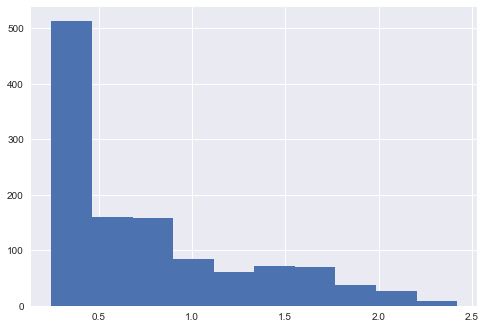

In [66]:
pred['wickets_taken_bowl_first'].hist()

In [69]:
pred.loc[pred['wickets_taken_bowl_first'] >= 2.2, 'wickets_taken_bowl_first'] = 3
pred.loc[(pred['wickets_taken_bowl_first'] >= 1.75) & 
         (pred['wickets_taken_bowl_first'] < 2.2), 'wickets_taken_bowl_first'] = 2
pred.loc[(pred['wickets_taken_bowl_first'] < 1.75) & (pred['wickets_taken_bowl_first'] > 1), 'wickets_taken_bowl_first'] = 1
pred.loc[(pred['wickets_taken_bowl_first'] > 0.70) & (pred['wickets_taken_bowl_first'] < 1), 'wickets_taken_bowl_first'] = 1
pred.loc[(pred['wickets_taken_bowl_first'] <= 0.70), 'wickets_taken_bowl_first'] = 0

In [70]:
pred.groupby('bowler')['wickets_taken_bowl_first'].apply(lambda x: x.sum()).sort_values(ascending=False)

bowler
B Kumar                 28.0
Krunal Pandya           25.0
Axar Patel              25.0
Sunil Narine            24.0
Yuzvendra Chahal        22.0
Jasprit Bumrah          20.0
Mohit Sharma            18.0
Harbhajan Singh         18.0
Dwayne Bravo            17.0
Imran Tahir             17.0
Amit Mishra             16.0
Chris Morris            16.0
Umesh Yadav             16.0
Andre Russell           16.0
Pat Cummins             14.0
Mohammed Siraj          14.0
Ravindra Jadeja         14.0
Dhawal Kulkarni         14.0
Rashid Khan             14.0
Virat Kohli             14.0
Mitchell Johnson        14.0
Kuldeep Yadav           14.0
Shane Watson            14.0
Jaydev Unadkat          14.0
Ben Stokes              14.0
Kieron Pollard          14.0
Yuvraj Singh            13.0
Siddarth Kaul           13.0
Andrew Tye              13.0
Shardul Thakur          12.0
Shahbaz Nadeem          12.0
Mustafizur Rahman       12.0
Ravichandran Ashwin     12.0
Trent Boult             11.0
Pawan N

In [71]:
## tweaks 

pred.loc[pred['bowler'] == 'Virat Kohli','wickets_taken_bowl_first'] = 0
pred.loc[pred['bowler'] == 'Hardik Pandya','wickets_taken_bowl_first'] = 1
pred.loc[pred['bowler'] == 'Yuvraj Singh','wickets_taken_bowl_first'] = 0

In [72]:
##saving

submission = test_player[['player_id', 'playing_xi_flag','match_id']]
submission = submission.merge(pred[['player_id', 'match_id','wickets_taken_bowl_first']] ,on =['match_id','player_id'], how='left')

###  for 2 inngs

In [73]:
## selecting only playing xi players
testing = test_player[test_player['playing_xi_flag'] == 1][['unique_id', 'match_id','player_id']]

In [74]:
testing2 = testing.merge(bowler[['bowler', 'player_id', 'overs_bowled2', 'consistency2',
       'wickets2', 'attacking2', 'dot%2', 'strike_rate2', 'hauls', 'mom2', 'bharosa2', 'experience2', 'avg_wickets2', 
                                 'role', 'bowling_style', 'bowling_arm','Price', 'country']], on='player_id', how='left')

In [75]:
testing2.head()

,unique_id,match_id,player_id,bowler,overs_bowled2,consistency2,wickets2,attacking2,dot%2,strike_rate2,hauls,mom2,bharosa2,experience2,avg_wickets2,role,bowling_style,bowling_arm,Price,country
0,2018_1_1,2018_1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018_1_24,2018_1,24,Suresh Raina,22.0,8.000000,0.0,0.000000,0.310606,0.000000,0.0,4.0,2.0,9.0,0.000000,Batsman,Offbreak,Right-Arm,1100.0,India
2,2018_1_114,2018_1,114,Dwayne Bravo,50.0,7.700000,19.0,0.380000,0.313333,6.333333,1.0,1.0,6.0,15.0,1.266667,Batting Allrounder,Fast-Medium,Right-Arm,640.0,Windies
3,2018_1_131,2018_1,131,Harbhajan Singh,73.0,7.835616,18.0,0.246575,0.369863,4.109589,0.0,2.0,17.0,19.0,0.947368,Bowler,Offbreak,Right-Arm,200.0,India
4,2018_1_175,2018_1,175,Shane Watson,61.0,7.524590,19.0,0.311475,0.428962,5.191257,1.0,2.0,11.0,19.0,1.000000,Batting Allrounder,Fast-Medium,Right-Arm,400.0,Australia


In [76]:
## adding other match details

testing2 = testing2.merge(test_matches[['match_id', 'team2_id', 'team1_id','venue_id']], on='match_id', how='left')

## adding batsman's team to find out the opp team

testing2 = testing2.merge(players[players['Season'] == 2018][['player_id', 'Team']], on ='player_id', how='left')

## finding out opponent team

testing2['batting_team'] = testing2['team1_id']

testing2.loc[testing2['batting_team'] == testing2["Team"], 'batting_team'] = testing2['team2_id']

testing2.drop(['team1_id','team2_id','Team'],axis=1,inplace=True)

In [77]:
## avg wickets aganist each team

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'batting_team'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_aganist'})

testing2 = testing2.merge(temp, on= ['bowler','batting_team'], how='left')

In [78]:
## avg wickets at each venue

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()]
temp = temp[temp['inning'] == 2]
temp = temp[(temp['dismissal_kind'] != 'run out') ].groupby(['bowler', 'venue_id'])['player_dismissed'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns= {'player_dismissed':'wickets'})
temp = temp.rename(columns = {'wickets':'wickets_venue'})

testing2 = testing2.merge(temp, on= ['bowler','venue_id'], how='left')

In [79]:
## mean encoding

testing2['role'] = testing2['role'].map(role_enc2)
testing2['bowling_style'] = testing2['bowling_style'].map(style_enc2)
testing2['bowling_arm'] = testing2['bowling_arm'].map(arm_enc2)

In [80]:
testing2.fillna(0,inplace=True)

In [81]:
wickets2= rf2.predict(testing2[features2])

In [82]:
testing = testing.merge(bowler[['player_id','bowler']], on='player_id', how='left')

In [83]:
#pred = testing[['player_id', 'bowler','match_id']]
pred['wickets_taken_bowl_second'] = wickets2

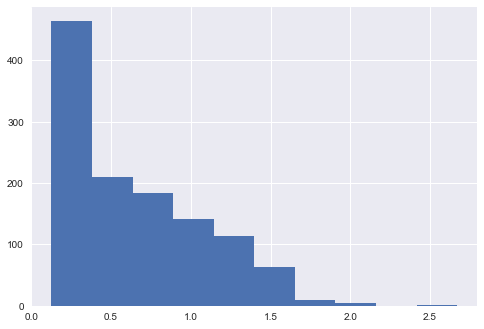

In [85]:
pred['wickets_taken_bowl_second'].hist()

In [87]:
pred.loc[pred['wickets_taken_bowl_second'] >= 2.1, 'wickets_taken_bowl_second'] = 3
pred.loc[(pred['wickets_taken_bowl_second'] >= 1.5) & 
         (pred['wickets_taken_bowl_second'] < 2.1), 'wickets_taken_bowl_second'] = 2
pred.loc[(pred['wickets_taken_bowl_second'] < 1.5) & (pred['wickets_taken_bowl_second'] > 1), 'wickets_taken_bowl_second'] = 1
pred.loc[(pred['wickets_taken_bowl_second'] > 0.60) & (pred['wickets_taken_bowl_second'] < 1), 'wickets_taken_bowl_second'] = 1
pred.loc[(pred['wickets_taken_bowl_second'] <= 0.60), 'wickets_taken_bowl_second'] = 0

In [102]:
#pred['wickets_taken_bowl_second'] = pred['wickets_taken_bowl_second'].round().astype('int')

In [89]:
pred.groupby('bowler')['wickets_taken_bowl_second'].apply(lambda x: x.sum()).sort_values(ascending=False)

bowler
Jaydev Unadkat          28.0
B Kumar                 26.0
Harbhajan Singh         19.0
Imran Tahir             18.0
Axar Patel              17.0
Yuzvendra Chahal        17.0
Amit Mishra             16.0
Mohit Sharma            15.0
Hardik Pandya           14.0
Jasprit Bumrah          14.0
Pawan Negi              14.0
Ben Stokes              14.0
Chris Morris            14.0
Kuldeep Yadav           14.0
Mitchell Johnson        14.0
Mohammed Siraj          14.0
Dhawal Kulkarni         14.0
Anureet Singh           14.0
Pat Cummins             14.0
Chris Woakes            14.0
Andrew Tye              14.0
Shardul Thakur          14.0
Virat Kohli             14.0
Vinay Kumar             14.0
Umesh Yadav             14.0
Trent Boult             14.0
Sunil Narine            14.0
Rahul Tripathi          14.0
Siddarth Kaul           14.0
Andre Russell           14.0
Rashid Khan             14.0
Shahbaz Nadeem          14.0
Ravichandran Ashwin     14.0
Mustafizur Rahman       13.0
Yuvraj 

In [90]:
## tweaks 

pred.loc[pred['bowler'] == 'Virat Kohli','wickets_taken_bowl_second'] = 0
pred.loc[pred['bowler'] == 'Anureet Singh','wickets_taken_bowl_second'] = 0
pred.loc[pred['bowler'] == 'Rahul Tripathi','wickets_taken_bowl_second'] = 0
pred.loc[pred['bowler'] == 'Yuvraj Singh','wickets_taken_bowl_second'] = 0
pred.loc[pred['bowler'] == 'Deepak Hooda','wickets_taken_bowl_second'] = 0

In [91]:
pred.groupby('bowler').agg({'wickets_taken_bowl_first':'sum',
                           'wickets_taken_bowl_second':'sum'}).sort_values(ascending=False, by = ['wickets_taken_bowl_first'])

,wickets_taken_bowl_first,wickets_taken_bowl_second
bowler,,
B Kumar,28.0,26.0
Axar Patel,25.0,17.0
Krunal Pandya,25.0,1.0
Sunil Narine,24.0,14.0
Yuzvendra Chahal,22.0,17.0
Jasprit Bumrah,20.0,14.0
Harbhajan Singh,18.0,19.0
Mohit Sharma,18.0,15.0
Imran Tahir,17.0,18.0


In [92]:
submission = submission.merge(pred[['player_id', 'match_id','wickets_taken_bowl_second']] ,on =['match_id','player_id'], how='left')

In [93]:
submission

,player_id,playing_xi_flag,match_id,wickets_taken_bowl_first,wickets_taken_bowl_second
0,1,1.0,2018_1,0.0,0.0
1,24,1.0,2018_1,0.0,0.0
2,114,1.0,2018_1,2.0,0.0
3,131,1.0,2018_1,2.0,1.0
4,175,1.0,2018_1,1.0,1.0
5,177,1.0,2018_1,1.0,1.0
6,189,1.0,2018_1,0.0,0.0
7,249,1.0,2018_1,0.0,0.0
8,254,0.0,2018_1,NaN,NaN
9,309,0.0,2018_1,NaN,NaN


In [94]:
submission.fillna(0, inplace=True)

In [95]:
submission[['playing_xi_flag', 'wickets_taken_bowl_first' , 'wickets_taken_bowl_second']] = submission[['playing_xi_flag', 'wickets_taken_bowl_first' , 'wickets_taken_bowl_second']].astype('int')

In [96]:
submission

,player_id,playing_xi_flag,match_id,wickets_taken_bowl_first,wickets_taken_bowl_second
0,1,1,2018_1,0,0
1,24,1,2018_1,0,0
2,114,1,2018_1,2,0
3,131,1,2018_1,2,1
4,175,1,2018_1,1,1
5,177,1,2018_1,1,1
6,189,1,2018_1,0,0
7,249,1,2018_1,0,0
8,254,0,2018_1,0,0
9,309,0,2018_1,0,0


In [97]:
submission.to_csv('saved/sub_wickets.csv', index=False)